In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data, info = tfds.load("colorectal_histology", split="train", as_supervised=True, with_info=True)


In [3]:
# Define the slice ranges
train_size = 4000
test_size = 500  # From index 3500 to 4000
unlabeled_size = 500  # From index 4000 to 5000

# Create the training dataset (first 3500 samples)
train_data = data.take(train_size)

# Skip the training samples and take the next 500 for testing
test_data = data.skip(train_size).take(test_size)

# Skip the first 4000 samples (train + test) and take the remaining for unlabeled data
unlabeled_data = data.skip(train_size + test_size).take(unlabeled_size)

# Optionally, print sizes for verification
print(f"Train size: {len(list(train_data))}")
print(f"Test size: {len(list(test_data))}")
print(f"Unlabeled size: {len(list(unlabeled_data))}")


Train size: 4000
Test size: 500
Unlabeled size: 500


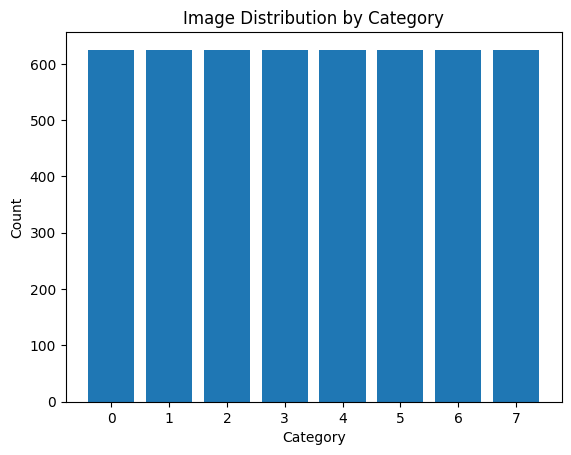

In [4]:
category_counts = {}
for image, label in data:
    label = label.numpy()
    category_counts[label] = category_counts.get(label, 0) + 1

# Plot category distribution
categories, counts = zip(*sorted(category_counts.items()))
plt.bar(categories, counts)
plt.title("Image Distribution by Category")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()

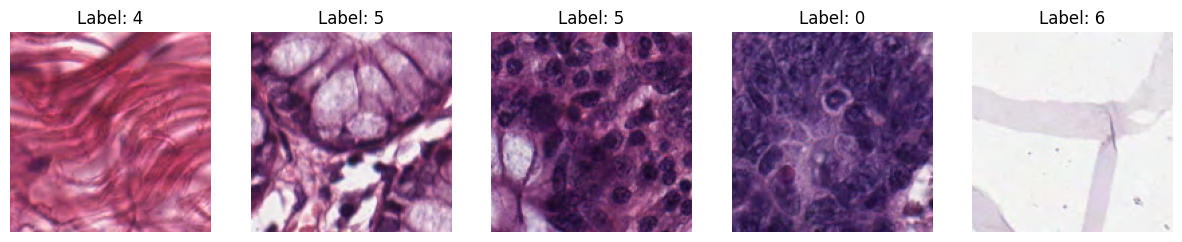

In [5]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, (image, label) in enumerate(data.take(5)):
    axes[i].imshow(image.numpy().astype("uint8"))
    axes[i].set_title(f"Label: {label.numpy()}")
    axes[i].axis("off")

In [6]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

def augment(image, label):
    image = data_augmentation(image)
    return image, label

labeled_data = train_data.map(augment)

In [7]:
def preprocess_image(image, target_size=(150, 150)):
    image = tf.image.resize(image, target_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image

train_data = train_data.map(lambda x, y: (preprocess_image(x), y)).batch(32)
test_data = test_data.map(lambda x, y: (preprocess_image(x), y)).batch(32)
unlabeled_data = unlabeled_data.map(lambda x, _: preprocess_image(x)).batch(32)


Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 91s 76ms/step - accuracy: 0.7683 - loss: 0.6850
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.9188 - loss: 0.2497
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.9574 - loss: 0.1256
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 83ms/step - accuracy: 0.9590 - loss: 0.1258
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 72ms/step - accuracy: 0.9655 - loss: 0.1150
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 439ms/step - accuracy: 0.5263 - loss: 4.2477
Test Loss: 4.35
Test Accuracy: 0.51


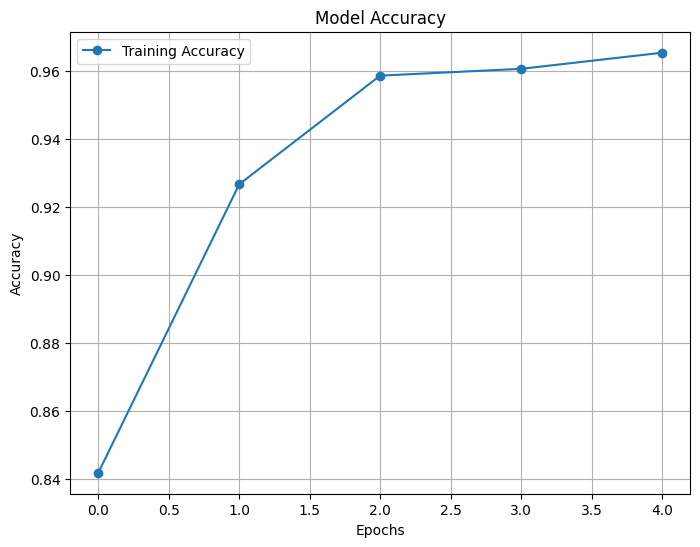

In [8]:
# Train the model with validation_split
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0

# Define a CNN model using EfficientNet
base_model = EfficientNetB0(input_shape=(150, 150, 3), include_top=False, weights='imagenet')
base_model.trainable = True

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(8, activation='softmax')  # 8 classes
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model using the labeled data
history = model.fit(train_data, epochs=5)

loss, accuracy = model.evaluate(test_data)
print(f"Test Loss: {loss:.2f}")
print(f"Test Accuracy: {accuracy:.2f}")

# Plot Accuracy and Loss
def plot_metrics(history, metric, title):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history[metric], label=f"Training {metric.capitalize()}", marker="o")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot accuracy
plot_metrics(history, "accuracy", "Model Accuracy")

In [9]:
pseudo_labels = []

for batch in unlabeled_data:
    predictions = model.predict(batch)
    pseudo_labels.extend(np.argmax(predictions, axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


In [10]:
unlabeled_images = []
for batch in unlabeled_data:
    unlabeled_images.extend(batch.numpy())

unlabeled_images = np.array(unlabeled_images)
pseudo_labels = np.array(pseudo_labels)

pseudo_labeled_data = tf.data.Dataset.from_tensor_slices((unlabeled_images, pseudo_labels)).batch(32)

combined_data = train_data.concatenate(pseudo_labeled_data)


Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 49s 350ms/step - accuracy: 0.9672 - loss: 0.1128
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.8299 - loss: 0.6043
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.8341 - loss: 0.5721
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.8603 - loss: 0.4170
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.8863 - loss: 0.3477
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - accuracy: 0.8989 - loss: 0.3089
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.9332 - loss: 0.2001
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 86ms/step - accuracy: 0.9234 - loss: 0.2169
Epoch 9/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.9360 - loss: 0.1931
Epoch 10/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.9400 - loss: 0.2109
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6466 - loss: 1.7066
Test Loss: 1.66
Test Accuracy: 0.66


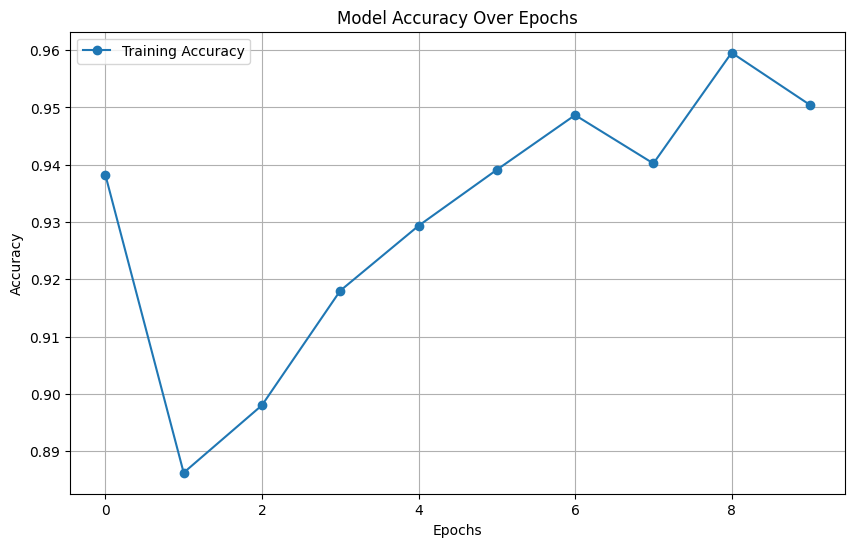

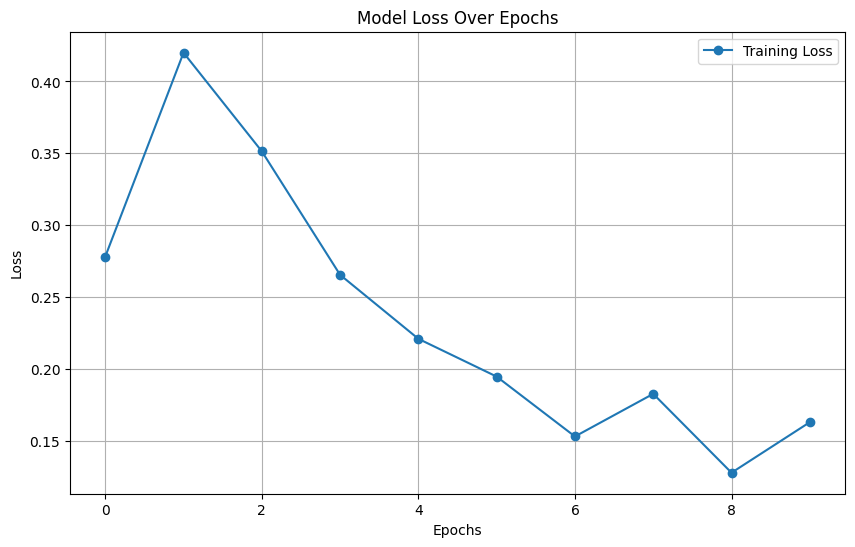

In [11]:
import matplotlib.pyplot as plt

# Replace this with your actual training history object from model.fit()
history = model.fit(
    combined_data,
    epochs=10
)

loss, accuracy = model.evaluate(test_data)
print(f"Test Loss: {loss:.2f}")
print(f"Test Accuracy: {accuracy:.2f}")

# Plot training and validation accuracy
def plot_metrics(history, metric, title, ylabel):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history[metric], label=f"Training {metric.capitalize()}", marker="o")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

# Generate the accuracy plot
plot_metrics(history, "accuracy", "Model Accuracy Over Epochs", "Accuracy")

# Generate the loss plot
plot_metrics(history, "loss", "Model Loss Over Epochs", "Loss")


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6466 - loss: 1.7066
Test Loss: 1.66
Test Accuracy: 0.66
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 703ms/step
Classification Report:
                           precision    recall  f1-score   support

        Tumour Epithelium       0.58      0.69      0.63        64
            Simple Stroma       0.35      1.00      0.52        59
           Complex Stroma       1.00      0.07      0.13        71
Immune Cell Conglomerates       1.00      0.23      0.37        66
         Debris and Mucus       0.95      0.54      0.69        68
           Mucosal Glands       0.85      1.00      0.92        50
           Adipose Tissue       0.86      0.98      0.92        61
               Background       0.92      1.00      0.96        61

                 accuracy                           0.66       500
                macro avg       0.81      0.69      0.64       500
             weighted avg       0.82      0.66      0.62       500



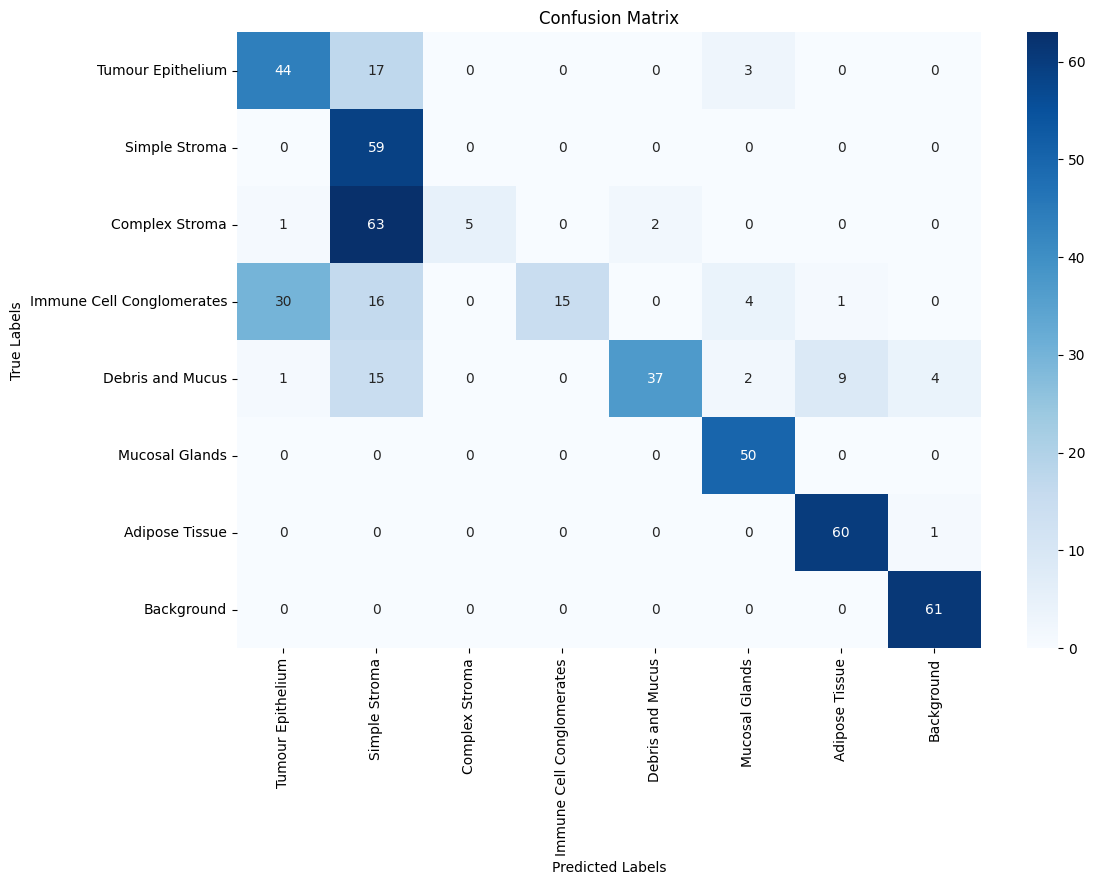

Precision for Tumour Epithelium: 0.58


In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Class names for the dataset
class_names = [
    "Tumour Epithelium",
    "Simple Stroma",
    "Complex Stroma",
    "Immune Cell Conglomerates",
    "Debris and Mucus",
    "Mucosal Glands",
    "Adipose Tissue",
    "Background"
]

# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_data)
print(f"Test Loss: {loss:.2f}")
print(f"Test Accuracy: {accuracy:.2f}")

# Generate predictions
y_pred_probs = model.predict(test_data)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true labels from the test data
y_true = np.concatenate([y.numpy() for _, y in test_data], axis=0)

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Store metrics for later analysis (optional)
metrics = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

# Example: Access precision for a specific class
print(f"Precision for Tumour Epithelium: {metrics['Tumour Epithelium']['precision']:.2f}")


In [14]:
# Save the entire model to a file
model.save("efficientnet_model.h5")

# Alternatively, save in TensorFlow SavedModel format
# Remove save_format="tf" and use .keras extension instead
model.save("efficientnet_model_saved.keras")